In [4]:
# import sys
# !{sys.executable} -m pip install pandas

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# df['tag'] = df['tag'].map({'0': '0', 'S': '1', 'C': '2', 'G': '3', 'T': '4', 'B': '5','D': '6' })

In [5]:
path= '/Users/cmkerner/Documents/sailing_ml/data/ML Training Resources'
all_files = glob.glob(path + "/*.csv")

listOfNormalizedDatFrames = []
listofTags = []
track_num = len(all_files)


for i, filename in enumerate(all_files):
    dfSpecific = pd.read_csv(filename, index_col=None, header=0)
    
    #I was lazy and did not check where the NaNs where but they were being annoying so made them all 0s.
    dfSpecific.fillna(0, inplace= True)
    dfSpecific['track_id'] = filename.split('/')[-1]
    dfSpecific['track_num'] = i
    
    dfSpecificY = dfSpecific[['tag']]
    dfSpecificY = dfSpecificY['tag'].astype('category')
#     dfSpecificY = dfSpecificY['tag'].map({'0': 0, 'S': 1, 'C': 2, 'G': 3, 'T': 4, 'B':5,'D': 6 })
    listofTags.append(dfSpecificY)
    dfSpecificX = dfSpecific.drop(columns=['tag_name', 'time'])
    # use this for predictions, drop tag feature
#     dfSpecificX = dfSpecific.drop(columns=['tag','tag_name', 'time'])

    
    #standardize data
    scaler = StandardScaler()
#     columnsBeingStandardize = ['lat', 'lon', 'sog', 'heel', 'clew_load','pitch']
    columnsBeingStandardize = ['sog', 'heel', 'clew_load','pitch']

    dfSpecificX[columnsBeingStandardize] = scaler.fit_transform(dfSpecificX[columnsBeingStandardize])
    
    listOfNormalizedDatFrames.append(dfSpecificX)

X = pd.concat(listOfNormalizedDatFrames, axis=0, ignore_index=True)
y = pd.concat(listofTags, axis=0, ignore_index=True)

In [6]:
kmeans = KMeans()
kmeans = KMeans(n_clusters=track_num, random_state=0).fit(X[['lon', 'lat']])
array = kmeans.predict(X[['lon', 'lat']])

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['cluster'] = kmeans.labels_

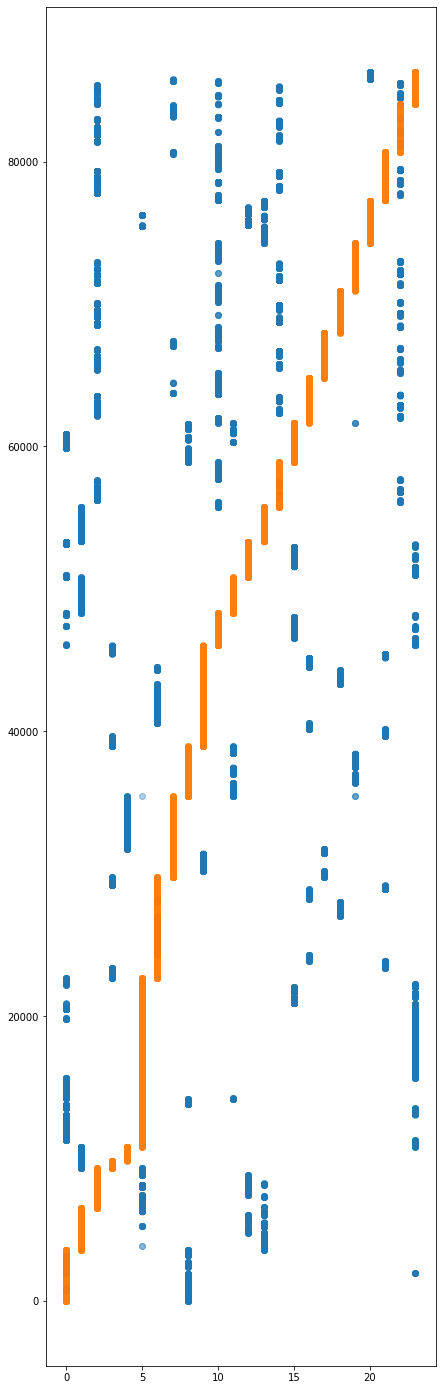

In [7]:
#clearly naive k-means does not group tracks, so this is just a pretty picture
fig, ax = plt.subplots(figsize = (7,25))
scatter = ax.scatter(cluster_map['cluster'], cluster_map['data_index'], cmap = 'rainbow', alpha = 0.1)
scatter = ax.scatter(X['track_num'], X.index, cmap = 'rainbow', alpha = 0.1)
plt.show()

In [8]:
#separating each location
#ik this is janky im sorry...
X.loc[((X.lat<(-38)) & (X.lat>(-39))), 'place'] = "stingaree"
X.loc[(X.lat>32) & (X.lat<33), 'place'] = "san diego"
X.loc[(X.lat>33) & (X.lat<34), 'place'] = "long beach"
X.loc[(X.lat>34) & (X.lat<35), 'place'] = "santa barbara"
X.loc[(X.lat>54) & (X.lat<55), 'place'] = "kiel"
X.place.value_counts()

stingaree        35231
kiel             24817
long beach       14168
san diego         6423
santa barbara     5679
Name: place, dtype: int64

In [9]:
#separating each track
tracks_df = X.groupby("track_id").agg(
    avg_lat=pd.NamedAgg(column='lat', aggfunc='mean'),
    avg_lon=pd.NamedAgg(column='lon', aggfunc='mean'),
    place=pd.NamedAgg(column='place', aggfunc='max'),
    boat_class=pd.NamedAgg(column='boat_class', aggfunc='max'))
tracks_df

,avg_lat,avg_lon,place,boat_class
track_id,,,,
MLData104.csv,-38.098237,144.405566,stingaree,Martine
MLData106.csv,-38.129773,144.401542,stingaree,Paris
MLData109.csv,-38.129686,144.401244,stingaree,Tamra
MLData117.csv,-38.132583,144.398022,stingaree,Tamra
MLData118.csv,-38.099889,144.404065,stingaree,Martine
MLData120.csv,54.435609,10.187614,kiel,Mathias Berthet
MLData121.csv,54.436456,10.189589,kiel,Mathias Berthet
MLData122.csv,54.436481,10.191511,kiel,Mathias Berthet
MLData123.csv,54.437564,10.189714,kiel,Mathias Berthet


In [ ]:
# tracks = X.groupby('track_id')
# track_info = pd.DataFrame()

# for (i, track) in tracks:
#     track_info[i] = {'boat_class' = np.all(track['boat_class']). 'place' = np.all(track['place']), 'avg_lat' = np.mean(track['lat']), np.mean(track['lon']))
# track_info

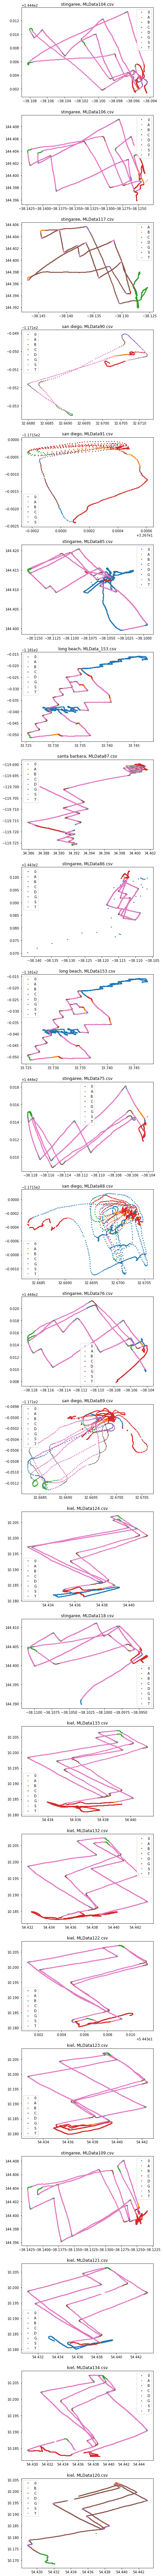

In [10]:
#show manueuves in color
tracks = X.groupby('track_num')
fig, axes = plt.subplots(track_num, figsize=(7, 140))
track_104 = pd.DataFrame()

for (num, track) in tracks:
    if num==0:
        track_104 = track
    manuevers = track.groupby('tag')
    for name, manuever in manuevers:
        axes[num].plot(manuever.lat, manuever.lon,marker='o', linestyle='', ms=2, label=name)
    axes[num].set_title(f"{track['place'].any()}, {track['track_id'].any()}")
    axes[num].legend()

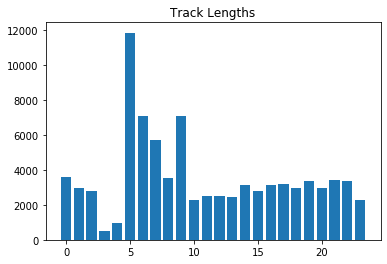

In [11]:
#examine track length
plt.bar(range(len(tracks)), [len(track) for num, track in tracks])
plt.title('Track Lengths')
plt.show()

In [12]:
#colors part of track labeled incorrectly when
#takes DF with lon and lat columns, preds series, true series
def quick_check(track, preds, trues):
    fig, axes = plt.subplots()
    matches = trues.eq(preds)
    track['matches'] = matches
    
    groups = track.groupby('matches')
    print('Percent Correct: ' + str(100*len(groups.get_group(True))/len(track)))
    for name, group in groups:
        axes.plot(group.lat, group.lon,marker='o', linestyle='', ms=2, label=name)
    axes.set_title(f"{track['place'].any()}, {track['track_id'].any()}")
    axes.legend()

In [13]:
#track that doesnt match true values
track_104.tag_bad = pd.Series(range(2000)).append(track_104.tag[2000:])

/Users/cmkerner/Google Drive/deepfake/detectors/DSP-FWA/FWA_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


Percent Correct: 44.351697273233164


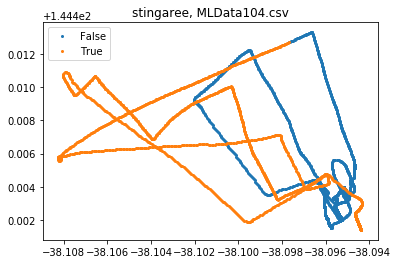

In [14]:
quick_check(track_104, track_104.tag, track_104.tag_bad)

In [27]:
import sys
# !echo {sys.executable}
!/Users/cmkerner/Google\ Drive/deepfake/detectors/DSP-FWA/FWA_env/bin/python3 -m pip install torchtext
!/Users/cmkerner/Google\ Drive/deepfake/detectors/DSP-FWA/FWA_env/bin/python3 -m pip install spacy
# !pip install torchtext

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
import numpy as np

import time
import random

You should consider upgrading via the '/Users/cmkerner/Google Drive/deepfake/detectors/DSP-FWA/FWA_env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/cmkerner/Google Drive/deepfake/detectors/DSP-FWA/FWA_env/bin/python3 -m pip install --upgrade pip' command.


In [28]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [29]:
LAT = data.Field(sequential=True)
LON = data.Field(sequential=True)
MAN_TAGS = data.Field(sequential = True, unk_token = None)

In [30]:
fields = (("lat", LAT), ("lon", LON), ("man_tags", MAN_TAGS))

In [31]:
tracks.first()

,lat,lon,sog,cog,boat_class,tag,heel,clew_load,pitch,rudder,track_id,place
track_num,,,,,,,,,,,,
0,-38.096232,144.403974,1.371637,-0.300000,Martine,S,0.000000,0.000000,0.000000,0.0,MLData104.csv,stingaree
1,-38.123810,144.398982,-1.693340,0.355556,Paris,A,0.000000,0.000000,0.000000,0.0,MLData106.csv,stingaree
2,-38.126875,144.397604,-1.277055,0.338889,Tamra,C,0.000000,0.000000,0.000000,0.0,MLData117.csv,stingaree
3,32.671131,-117.150075,0.155703,0.838889,B20808,C,-2.394842,-1.082471,1.568148,-12.8,MLData90.csv,san diego
4,32.670348,-117.150281,-1.267243,-0.261111,B20810-56,C,0.060064,-1.858481,0.058182,10.4,MLData91.csv,san diego
5,-38.107634,144.414144,-0.635198,0.811111,Steph,0,0.000000,0.000000,0.000000,0.0,MLData85.csv,stingaree
6,33.746611,-118.117401,-1.384477,0.000000,Gigi and Adra,0,0.000000,0.000000,0.000000,0.0,MLData_153.csv,long beach
7,34.387476,-119.699863,0.428977,-0.277778,B20725,S,-0.637039,1.619091,-0.438611,-11.5,MLData87.csv,santa barbara
8,-38.142022,144.370248,0.148999,0.050000,Martine,0,0.000000,0.000000,0.000000,0.0,MLData86.csv,stingaree


NameError: name 'torchtext' is not defined

In [ ]:
MIN_FREQ = 2

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)


UD_TAGS.build_vocab(train_data)
PTB_TAGS.build_vocab(train_data)